# Cluster Project

**Scenario**

Say we have a set of addresses on a map, which indicate at least one person living there.

**Assumptions**

For this example code, we assume to have the geolocation coordinates of each address. If not, it is possible to obtain those via the Google Maps Geolocation API.
We additionally assume that we have some kind of indicator attached to each point (geolocation) that shows how many people live at this point. For the example code, this is set to a mean of 2 within the example coordinates.

**Aim**

We want to be able to visit each point within a group once. Hereby, we aim to adhere to a maximum amount of people per point, as well as a maximum amount of distance travelled to visit each point once. Additionally, we set a maximum number of points per group to be respected.

**Approach**

I combine information from the following to reach the (tentative) aim:
1. Google Maps Distance Matrix API
    I use this API to calcuate the pairwise-distances between each point from the input coordinates. If I put 10 coordoinates, I expect a 10x10 square Matrix as result, with one row of 0s, the distance to itself.
2. Google Maps Route API
    This API is called to get the an overview of distance travelled (by car) for each cluster. It is the goal to specify a limit of how much doistance should be allowed to be covered for each group.
3. KNN Clustering Algorithm
    Last but not least, I apply simple KNN clustering, based on physical distances of each point (given by the Distance Matrix), instead of common Euclidian Distance. Then, I cluster group mmebership for each point, gives a dynamic number of k (number of clusters).


The following script shows a basic implementation of the KNN algorithm based on physical distance data obtained from the Google Maps Distance Matrix API.
This approach does not limit the clusters to a maximum threshold of people per cluster, neither to a maximum distance travelled in order to visit each coordinate point once. 
These adaptations are evolving and can be found in "advanced_function"

**Import modules** 

In [28]:
import numpy as np
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


### Google Maps Distance Matrix API

**Define the input data**

(On an Individual Account, the Google Maps Distance Marix APi can only handel a maximum of 25 points for either the origins or destinations. The entire demo is hence run on a set of 10 input coordinate points, which are set in Berlin, Germany)

In [19]:
# Set input coordinates
input_data = [
    {"latitude": 52.5163, "longitude": 13.3777},
    {"latitude": 52.5200, "longitude": 13.4049},
    {"latitude": 52.5244, "longitude": 13.4050},
    {"latitude": 52.5186, "longitude": 13.3759},
    {"latitude": 52.5138, "longitude": 13.3928},
    {"latitude": 52.5206, "longitude": 13.2951},
    {"latitude": 52.5219, "longitude": 13.4132},
    {"latitude": 52.5034, "longitude": 13.4375},
    {"latitude": 52.5043, "longitude": 13.3325},
    {"latitude": 52.5336, "longitude": 13.3818}
]

[[0, 2289, 3034, 1270, 2423, 5888, 2863, 5249, 4234, 2650], [2317, 0, 745, 3094, 1663, 8224, 574, 4196, 6570, 3448], [3141, 771, 0, 3917, 2486, 9047, 1345, 4073, 7393, 2712], [1365, 3155, 3695, 0, 3397, 6184, 3729, 6286, 4530, 2782], [1430, 1291, 2036, 2719, 0, 7337, 1865, 3760, 4778, 2904], [6389, 8639, 9384, 6618, 8420, 0, 9213, 11309, 4023, 10892], [3306, 1058, 1006, 4082, 2651, 9213, 0, 3846, 7558, 3460], [4917, 3993, 4306, 6206, 3873, 10824, 3971, 0, 8290, 6665], [4592, 6843, 7588, 4821, 5277, 3537, 7417, 8457, 0, 6794], [3676, 3588, 2633, 2895, 3715, 7922, 4162, 6732, 6805, 0]]


**Initiate the API Request**

In [ ]:
# Define origins and destination, which are required parameters in the API request
origins = "|".join([f"{point['latitude']},{point['longitude']}" for point in input_data])
destinations = "|".join([f"{point['latitude']},{point['longitude']}" for point in input_data])

# Set the url for the Distabce Matrix API
url = "https://maps.googleapis.com/maps/api/distancematrix/json"

# Set the parameters
params = {
    "origins": origins,
    "destinations": destinations,
    "key": "INSERT_API_KEY"
}

# Define response and result
response = requests.get(url, params=params)
api_result = response.json()

**Build Matrix**

In [ ]:
# Construct the Matrix as list
distance_matrix = []
for row in api_result['rows']:
    row_distances = [element['distance']['value'] for element in row['elements']]
    distance_matrix.append(row_distances)

print(distance_matrix)

In [20]:
# Convert list Matrix to numpy 2D-array
distance_matrix = np.array(distance_matrix)
print(distance_matrix)

[[    0  2289  3034  1270  2423  5888  2863  5249  4234  2650]
 [ 2317     0   745  3094  1663  8224   574  4196  6570  3448]
 [ 3141   771     0  3917  2486  9047  1345  4073  7393  2712]
 [ 1365  3155  3695     0  3397  6184  3729  6286  4530  2782]
 [ 1430  1291  2036  2719     0  7337  1865  3760  4778  2904]
 [ 6389  8639  9384  6618  8420     0  9213 11309  4023 10892]
 [ 3306  1058  1006  4082  2651  9213     0  3846  7558  3460]
 [ 4917  3993  4306  6206  3873 10824  3971     0  8290  6665]
 [ 4592  6843  7588  4821  5277  3537  7417  8457     0  6794]
 [ 3676  3588  2633  2895  3715  7922  4162  6732  6805     0]]


## KNN Clustering

In [21]:
# Set k = 2 for the demo due low number of input data
k = 2

# Fit the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0).fit(distance_matrix)

# Define and print the associated cluster labels
cluster_labels = kmeans.labels_
print("Cluster labels:", cluster_labels)

Cluster labels: [1 1 1 1 1 0 1 1 0 1]


## Visualize

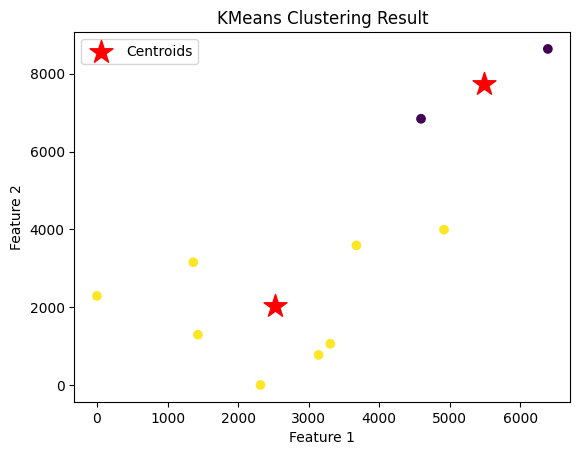

In [22]:

plt.scatter(distance_matrix[:, 0], distance_matrix[:, 1], c=cluster_labels, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='*', s=300, label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering Result')
plt.legend()
plt.show()

## Build Function to automate:

This should return the same clusters and plot as the approach above

In [23]:
def cluster_voters(input_data, k):
    origins = "|".join([f"{point['latitude']},{point['longitude']}" for point in input_data])
    destinations = "|".join([f"{point['latitude']},{point['longitude']}" for point in input_data])

    url = "https://maps.googleapis.com/maps/api/distancematrix/json"

    params = {
        "origins": origins,
        "destinations": destinations,
        "key": "INSERT_API_KEY"
    }
    response = requests.get(url, params=params)
    api_result = response.json()

    distance_matrix = []
    for row in api_result['rows']:
        row_distances = [element['distance']['value'] for element in row['elements']]
        distance_matrix.append(row_distances)

    distance_matrix = np.array(distance_matrix)

    kmeans = KMeans(n_clusters=k, random_state=0).fit(distance_matrix)

    return kmeans.labels_

In [25]:
cluster_labels = cluster_voters(input_data, 2)

print(cluster_labels)

[1 1 1 1 1 0 1 1 0 1]


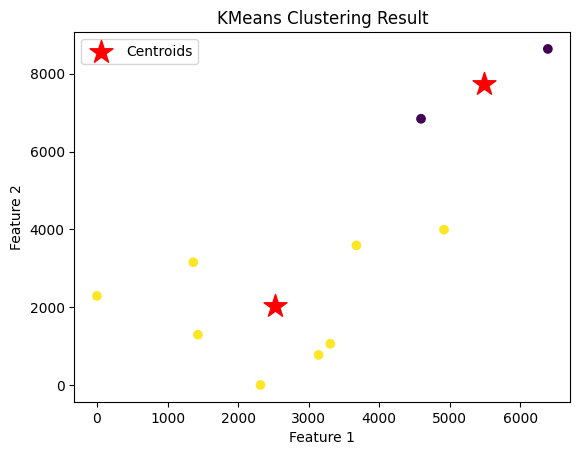

In [27]:
# Assuming you already have `cluster_labels` and `distance_matrix` defined

# Scatter plot the clusters
plt.scatter(distance_matrix[:, 0], distance_matrix[:, 1], c=kmeans.labels_, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='*', s=300, label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering Result')
plt.legend()
plt.show()